In [10]:
from pprint import pprint
import os
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import mplleaflet as leaf
from importlib import reload

In [11]:
base_path = os.path.join('C:\\', 'Users', 'glenn', 'src', 'pycommute')
data_directory = os.path.join(base_path, 'data')
dataframe_file = os.path.join(data_directory, 'trondheim_300m_correct.hdf5')
df = pd.read_hdf(dataframe_file)

Get destination coordinates

In [12]:
labels = ('Lerkendal Stadion', 'Ikea')
coords_1 = tuple(df.loc[df['destination label'] == labels[0]][['destination lat', 'destination lon']].iloc[0])
coords_2 = tuple(df.loc[df['destination label'] == labels[1]][['destination lat', 'destination lon']].iloc[0])

Create matrices

In [13]:
def arrays_to_matrices(latitudes, longitudes, values, return_coordinates='list'):
    """
    Function turns lists of latitudes, longitudes and values into matrix values where the first axis (0) is latitudes, and the second axis (1) is longitudes.
    """
    lats = sorted(set(latitudes))
    lons = sorted(set(longitudes))
    i_lats = {}
    for i, lat in enumerate(lats):
        i_lats[lat] = i
    i_lons = {}
    for i, lon in enumerate(lons):
        i_lons[lon] = i
    vals = np.full((len(lats), len(lons)), np.nan)
    for lat, lon, val in zip(latitudes, longitudes, values):
        vals[i_lats[lat], i_lons[lon]] = val
    
    if return_coordinates is None:
        return vals
    elif return_coordinates == 'matrix':
        lats, lons = np.meshgrid(lats, lons)
    elif return_coordinates == 'list':
        pass
    else:
        raise ValueError('`return_coordinates` must be either type None, strings `list` or `matrix`.')
    
    return lats, lons, vals
    


Get arrays

In [14]:
def get_mode(df, travel_mode, destination_label):
    selection = df.loc[
        (df['travel mode'] == travel_mode) &
        (df['destination label'] == destination_label)
    ]
    out = {
        'latitudes': np.array(selection['origin lat']),
        'longitudes': np.array(selection['origin lon']),
        'durations': np.array(selection['duration value']),
        'distances': np.array(selection['distance value']),
    }

    return out


In [15]:
d_1_driving = get_mode(df, 'driving', labels[0])
d_1_transit = get_mode(df, 'transit', labels[0])
d_2_driving = get_mode(df, 'driving', labels[1])
d_2_transit = get_mode(df, 'transit', labels[1])

lats = d_1_driving['latitudes']
lons = d_1_driving['longitudes']

Compare

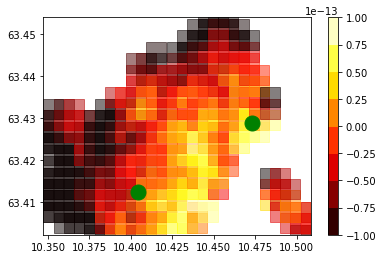

In [20]:
norm_ord = np.inf
top_cutoff_percent = 20 # Higher than this percentile (from top) get mapped to this percentile
score_multiplier = 1 / 60 # to minutes

scores = {
    'no_driving': np.linalg.norm((d_1_transit['durations'], d_2_transit['durations']), ord=norm_ord, axis=0),
    '1_driving': np.linalg.norm((d_1_driving['durations'], d_2_transit['durations']), ord=norm_ord, axis=0),
    '2_driving': np.linalg.norm((d_1_transit['durations'], d_2_driving['durations']), ord=norm_ord, axis=0),
    'all_driving': np.linalg.norm((d_1_driving['durations'], d_2_driving['durations']), ord=norm_ord, axis=0),
}

for key, score in scores.items():
    cutoff = np.percentile(score, 100-top_cutoff_percent)
    scores[key] = np.minimum(score, cutoff) * score_multiplier

score_args = {'x': lons, 'y': lats, 'c': -scores['all_driving'], 'cmap': 'hot', 'marker': 's', 's': 20**2, 'alpha': 0.5}
lat_list, lon_list, score_matrix = arrays_to_matrices(lats, lons, -scores['1_driving'])
score_contour_args = [lon_list, lat_list, score_matrix]
score_contour_kwargs = {'cmap': 'hot'}
#score_contour_kwargs = {}
destination_args = {'x': (coords_1[1], coords_2[1]), 'y': (coords_1[0], coords_2[0]), 'c': 'green', 's': 15**2}

plt.figure()
plt.scatter(**score_args)
plt.contourf(*score_contour_args, **score_contour_kwargs)
plt.colorbar()
plt.scatter(**destination_args)
plt.show()

In [21]:
plt.figure()
plt.scatter(**score_args)
plt.contour(*score_contour_args, **score_contour_kwargs)
plt.scatter(**destination_args)
leaf.show()